<a href="https://colab.research.google.com/github/CristianCosci/LAB_MachineLearning_course/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
import random
model_filepath = 'image_anomaly_ae.h5'

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/fruits_anomaly_detection.zip"

In [ ]:
# Create generators for training, validation and testing
# Generate data from the images in a folder, allows use of datasets that do not fit in main memory all at once
# Image resizing is done by the generator so a folder with any sized-images can be used
# The named directory must contain one or more subfolders, path should look like apples_train/apple_class1/img1.jpg...

#Generate batches of tensor image data with real-time data augmentation.

#A DirectoryIterator yielding tuples of (x, y) 
#where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.

#flow_from_directory(directory), 
#Description:Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

batch_size = 85
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last') # 96x96x3
train_generator = train_datagen.flow_from_directory(
    '/content/fruits_anomaly_detection/apples_train',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = test_datagen.flow_from_directory(
    '/content/fruits_anomaly_detection/apples_test/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = test_datagen.flow_from_directory(
    '/content/fruits_anomaly_detection/eggplant',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )
#(X, y)

**Build Autoencoder**

note to self: conv2d+upsampling seems to be better than conv2dtranspose according to https://distill.pub/2016/deconv-checkerboard/



In [ ]:
# Define the convolutional autoencoder model 
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
model = Sequential()

# ENCODER
model.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(96, 96, 3))) # the input shape parameter is the same if i declare an input layer before this Conv2D
model.add(MaxPooling2D(pool_size=(4,4), padding='same')) # using pool_size (4,4) makes the layer 4x smaller in height and width

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(4,4), padding='same'))

model.add(Conv2D(3,(3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# DECODER
model.add(Conv2D(3, (3, 3), activation = "relu", padding = "same"))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(8, (3, 3), activation = "relu", padding = "same"))
model.add(UpSampling2D((4, 4)))

model.add(Conv2D(16, (3, 3), activation ="relu", padding = "same"))
model.add(UpSampling2D((4,4))) #96x96x 16-> 3 = rgb

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same')) # this layer transoform the output in the correct shape 96x96x3

#-------------------------

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error') # difference between input images and output images -> (we can use also MAE: mean absolute error)

**Training**

In [ ]:
#steps_per_epoch: Integer. Total number of steps (batches of samples) to yield from generator 
# before declaring one epoch finished and starting the next epoch. It should typically be 
# equal to ceil(num_samples / batch_size). Optional for Sequence: if unspecified, 
# will use the len(generator) as a number of steps.

# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min', verbose = 1) # Saves the best version of the model to disk (as measured on the validation data set)

# model.fit(X_train, y_train, etc..) solitamente si faceva così
model.fit(train_generator, #-> (X,y) ~~ (X_train, y_train) -> generator output (X, X) , class_mode = input
        steps_per_epoch = train_generator.samples // train_generator.batch_size,
        epochs=50,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // validation_generator.batch_size,
        shuffle = True,
        callbacks=[es, save_best])

In [ ]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/"+model_filepath)
model.summary()

In [9]:
# Test the model by viewing a sample of original and reconstructed images

#A DirectoryIterator yielding tuples of (x, y) 
#where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels. 

# get extract some batches with the generator
data_list = []
batch_index = 0
print(dir(train_generator)) # 6416/85 ~ 75 batches
while batch_index <= train_generator.batch_index:
    print("batch_index: ", batch_index, "train_generator batch_index: ", train_generator.batch_index) #; train_generator has 6416 images with a batch size of 85 results in aprox 75 batches
    data = train_generator.next()  #data[0].shape = (85, 96, 96, 3) they are the input batch, data[1].shape = (85, 96, 96, 3), they are the output batch. 
    # generator return a tuple T : (x,y)
    # T[0]: input batches
    # T[1]: data for output batches
    data_list.append(data[0]) #just get the input batches
    batch_index = batch_index + 1

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_filepaths', '_flow_index', '_get_batches_of_transformed_samples', '_keras_api_names', '_keras_api_names_v1', '_set_index_array', 'allowed_class_modes', 'batch_index', 'batch_size', 'class_indices', 'class_mode', 'classes', 'color_mode', 'data_format', 'directory', 'dtype', 'filenames', 'filepaths', 'image_data_generator', 'image_shape', 'index_array', 'index_generator', 'interpolation', 'labels', 'lock', 'n', 'next', 'num_classes', 'on_epoch_end', 'reset', 'sample_weight', 'samples', 'save_format', 'save_prefix', 'save_to_dir', 'seed', 'set_processing_attrs', 'shuffle', 'split', 'subset', 'target

In [10]:
print(len(data_list))
print(data_list[0].shape)

76
(85, 96, 96, 3)


data_list lenght 76
(85, 96, 96, 3)


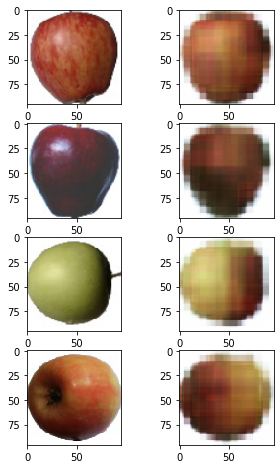

In [11]:
#plot some original samples vs reconstructed samples
print("data_list lenght", len(data_list))
print(data_list[0].shape) #first batch stored in data_list

predicted = model.predict(data_list[0])   #compute prediction for this batch

no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(data_list[0][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [12]:
#get images from eggplant (which we consider to be anomalous data)

# Test the model by viewing a sample of original and reconstructed images
eggplant_data_list = []
batch_index = 0
while batch_index <= anomaly_generator.batch_index:
    print("batch_index: ", batch_index, "anomaly_generator batch_index: ", anomaly_generator.batch_index) 
    data = anomaly_generator.next() #data[0].shape = (85, 96, 96, 3), data[1].shape = (85, 96, 96, 3), they are the input and output batch. 
    eggplant_data_list.append(data[0]) #just get the input batches
    batch_index = batch_index + 1

print(len(eggplant_data_list))
print(eggplant_data_list[0].shape)

batch_index:  0 anomaly_generator batch_index:  0
batch_index:  1 anomaly_generator batch_index:  1
batch_index:  2 anomaly_generator batch_index:  2
batch_index:  3 anomaly_generator batch_index:  3
batch_index:  4 anomaly_generator batch_index:  4
batch_index:  5 anomaly_generator batch_index:  5
6
(85, 96, 96, 3)


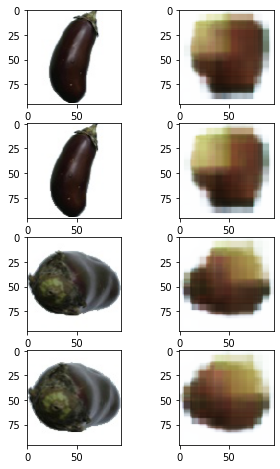

In [13]:
#plot some original eggplants vs reconstructed eggplants
predicted = model.predict(eggplant_data_list[1]) #get prediction/reconstructions for the first batch of eggplants
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(eggplant_data_list[1][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [14]:
#get images from apple test

# Test the model by viewing a sample of original and reconstructed images
apple_test_list = []
batch_index = 0
while batch_index <= validation_generator.batch_index:
    print("batch_index: ", batch_index, "validation_generator batch_index: ", validation_generator.batch_index) 
    data = validation_generator.next() 
    apple_test_list.append(data[0]) #just get the input batches
    batch_index = batch_index + 1
    
print(len(apple_test_list))
print(apple_test_list[0].shape)

batch_index:  0 validation_generator batch_index:  0
batch_index:  1 validation_generator batch_index:  1
batch_index:  2 validation_generator batch_index:  2
batch_index:  3 validation_generator batch_index:  3
batch_index:  4 validation_generator batch_index:  4
batch_index:  5 validation_generator batch_index:  5
batch_index:  6 validation_generator batch_index:  6
batch_index:  7 validation_generator batch_index:  7
batch_index:  8 validation_generator batch_index:  8
batch_index:  9 validation_generator batch_index:  9
batch_index:  10 validation_generator batch_index:  10
batch_index:  11 validation_generator batch_index:  11
batch_index:  12 validation_generator batch_index:  12
batch_index:  13 validation_generator batch_index:  13
batch_index:  14 validation_generator batch_index:  14
batch_index:  15 validation_generator batch_index:  15
batch_index:  16 validation_generator batch_index:  16
batch_index:  17 validation_generator batch_index:  17
batch_index:  18 validation_ge

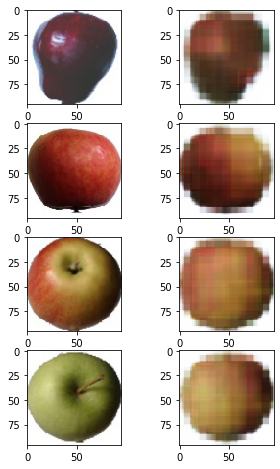

In [15]:
#apple test samples: original vs reconstructed
predicted = model.predict(apple_test_list[1])
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(apple_test_list[1][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [16]:
# evaluation
# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate(validation_generator)}, error on anomaly set:{model.evaluate(anomaly_generator)}") #MSE

6/6 [==============================] - 0s 66ms/step - loss: 0.0824
Error on validation set:0.017765231430530548, error on anomaly set:0.08235572278499603


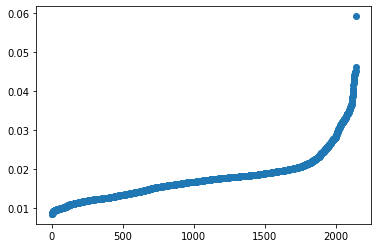

In [17]:
error_list = []
for idx in range(len(apple_test_list)): #iterate over batches

  r = model.predict(apple_test_list[idx])   #get prediction of batch with index idx

  #MSE
  r_error  = [np.square(apple_test_list[idx][i] - r[i]).mean() for i in range(len(apple_test_list[idx]))]
  error_list.append(r_error) #error_list is a list of list: so I will flatten everything out.


error_flat_list = [item for sublist in error_list for item in sublist]
# total_error = sum(error_flat_list)

plt.scatter(x = range(len(error_flat_list)), y = sorted(error_flat_list))

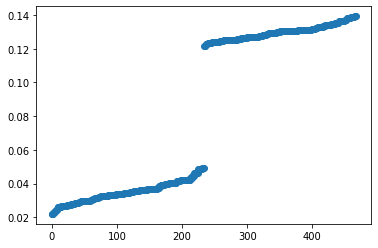

In [18]:
# get the reconstructions errors for eggplants
error_list_eggplant = []
for idx in range(len(eggplant_data_list)):
  # eggplant_anomaly = np.array(eggplant_data_list[idx])

  r = model.predict(eggplant_data_list[idx])

  r_error  = [np.square(eggplant_data_list[idx][i] - r[i]).mean() for i in range(len(eggplant_data_list[idx]))]

  error_list_eggplant.append(r_error)

error_flat_list_eggplant = [item for sublist in error_list_eggplant for item in sublist]
# total_error = sum(error_flat_list_eggplant)

plt.scatter(x = range(len(error_flat_list_eggplant)), y = sorted(error_flat_list_eggplant))

In [19]:
# count anomalies on apple test given a threshold
#anomaly detection on apple_test samples
count_anomaly = 0
threshold = 0.04

count_anomaly = sum(i > threshold for i in error_flat_list) #apples has MSE -label 0
count_normal = sum(i <= threshold for i in error_flat_list)
print("apple test anomaly {} over a total of {} apple test".format(count_anomaly, len(error_flat_list)))
print(count_anomaly/(len(error_flat_list)))

apple test anomaly 20 over a total of 2143 apple test
0.009332711152589827


In [20]:
#count anomalies on eggplants
#anomaly detection in the eggplant samples
count_anomaly = 0
threshold = 0.04

count_anomaly = sum(i > threshold for i in error_flat_list_eggplant)#eggplant has MSE -label 1
count_normal = sum(i <= threshold for i in error_flat_list_eggplant)

print("eggplant anomaly {} over a total of {} apple test".format(count_anomaly, len(error_flat_list_eggplant)))
print(count_anomaly/(len(error_flat_list_eggplant)))

eggplant anomaly 288 over a total of 468 apple test
0.6153846153846154


In [21]:
# ROC curve
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import pandas as pd

#assign labels
#create labels for normal and anomaly samples
apple_test_labels =  np.zeros(len(error_flat_list))    #normal label = 0
eggplant_test_labels = np.ones(len(error_flat_list_eggplant)) #anomaly label = 1

# print(apple_test_labels)
# print(eggplant_test_labels)
# put all the labels together
#y_test: ground truth
all_labels = np.concatenate((apple_test_labels, eggplant_test_labels))

# print(all_labels.shape)
# print(all_labels)

# put together the reconstruction errors
#target_scores
all_errors  = error_flat_list + error_flat_list_eggplant
# print(len(all_errors))
# print(all_errors)
# print(error_flat_list)

#TO DO: create a dataframe to store all the above information, to have everything together
#this way we can compute some statistics easily

error_df = pd.DataFrame({'reconstruction_error': all_errors,
                         "true_class": all_labels})
error_df.describe()
print(error_df.head())
print(error_df.tail())

   reconstruction_error  true_class
0              0.017183         0.0
1              0.020247         0.0
2              0.011626         0.0
3              0.017519         0.0
4              0.019485         0.0
      reconstruction_error  true_class
2606              0.136149         1.0
2607              0.125711         1.0
2608              0.028003         1.0
2609              0.034537         1.0
2610              0.029545         1.0


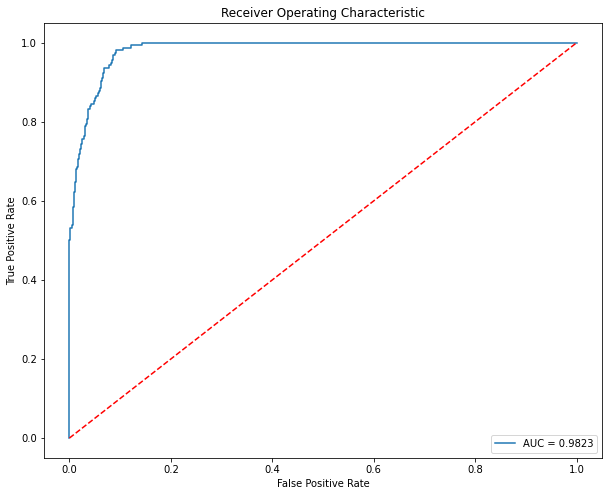

In [22]:
# ROC curve
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
# fpr, tpr, thresholds = roc_curve(all_labels, all_errors)

# AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
#plt.xlim([-0.001, 1])
#plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show();

**OneClass SVM for anomaly detection**

 SVMs use hyperplanes in multi-dimensional space to separate one class of observations from another. Naturally, SVM is used in solving multi-class classification problems.

However, SVM is also increasingly being used in one class problem, where all data belong to a single class. In this case, the algorithm is trained to learn what is “normal”, so that when a new data is shown the algorithm can identify whether it should belong to the group or not. If not, the new data is labeled as out of ordinary or anomaly.

In [23]:
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs
from numpy import quantile, where, random
import matplotlib.pyplot as plt

**Preparing the data**
We create a toy dataset for this tutorial by using the make_blob() function. We can check the dataset by visualizing it in a plot.



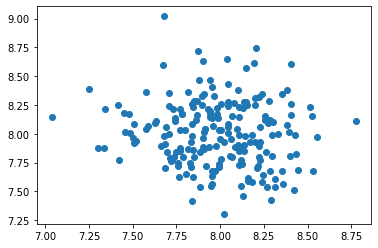

In [24]:
random.seed(13)
x, _ = make_blobs(n_samples=200, centers=1, cluster_std=.3, center_box=(8, 8))

plt.scatter(x[:,0], x[:,1])
plt.show()

**Defining the model and prediction**

OneClassSVM(gamma=0.001, nu=0.03)


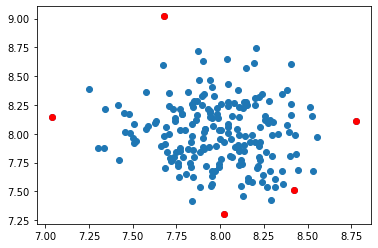

In [25]:
# create the model
#svm = OneClassSVM()
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.03)
print(svm)

# fit the model & predict 
svm.fit(x)
pred = svm.predict(x) #1 for inliers; -1 for outliers
# print(pred)

# extract the negative outputs as outliers
anom_index = where(pred == -1)
values = x[anom_index]

# visualize the results in a plot, highlighting with red the anomalies/outliers
plt.scatter(x[:,0], x[:,1])
plt.scatter(values[:,0], values[:,1], color='r')
plt.show()

OneClassSVM(gamma=0.001, nu=0.02)
3.994389673293594


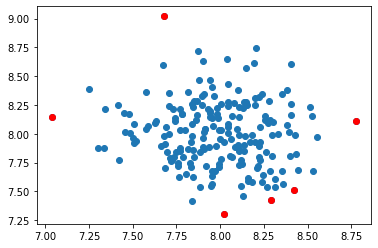

In [26]:
# anomaly detection with scores
# We can find anomalies by using their scores.
# In this method, we'll define the model, fit it on the x data by using the fit_predict() method. 
# We'll calculate the outliers according to the score value of each element.

svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.02)
print(svm)

# fit the model and extract sample scores
pred = svm.fit_predict(x)
scores = svm.score_samples(x)

#print(scores)

# get the threshold values from the scores using the quantile function
#for example, get the lowest 3-percent of score values as the anomalies
thresh = quantile(scores, 0.03)
print(thresh)

# extract the anomalies by comparing the threshold value and identify the values of elements
index = where(scores<=thresh)
values = x[index]

#visualize the data, anomalies are colored in red
plt.scatter(x[:,0], x[:,1])
plt.scatter(values[:,0], values[:,1], color='r')
plt.show()